# NBA Statistic Predictor


In [1]:
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## Abbreviation key
| Name | Description |
| :-- | :----: |
| gp | games played
| net_rating | offRating - defRating
| offRating | 100*((points)/num_possesions) (not in data)
| defRating | 100*((opp points/(opponents_num_possesions))) (not in data)
| oreb_pct | offensive rebound percentage
| usg_pct | percentage of team plays utilized by a player while they are in the game
| ts_pct | true shooting percentage;  percentage of shots made factoring in threes and free throws.  
| ast_ptg | assist percentage; percent of field goals (2 or 3 point shots not including free throws) 





In [2]:
# !wget https://github.com/morganjng/nba-classifier/blob/main/all_seasons.csv
csv = pd.read_csv("all_seasons.csv")

In [3]:
total_players = len(csv["player_name"])
print(csv.columns, total_players)
#print(csv)

Index(['Unnamed: 0', 'player_name', 'team_abbreviation', 'age',
       'player_height', 'player_weight', 'college', 'country', 'draft_year',
       'draft_round', 'draft_number', 'gp', 'pts', 'reb', 'ast', 'net_rating',
       'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct', 'season'],
      dtype='object') 11700


## Pre-processsing the dataset
### Building a function to return one-hot vectors for string entries in data

In [4]:
colleges = []
countries = []
years = []
seasons = []
teams = []
for i in range(0, total_players):
    if(csv["college"][i] not in colleges):
        colleges.append(csv["college"][i])
    if(csv["country"][i] not in countries):
        countries.append(csv["country"][i])
    if(csv["draft_year"][i] not in colleges):
        years.append(csv["draft_year"][i])
    if(csv["season"][i] not in seasons):
        seasons.append(csv["season"][i])
    if(csv["team_abbreviation"][i] not in teams):
        teams.append(csv["team_abbreviation"][i])
# print(colleges, countries, years, seasons, teams)

def one_hot(value, array):
    v = [0 for i in range(len(array))]
    v[array.index(value)] = 1
    return torch.Tensor(v)

### Handling n/a entries in the table

In [5]:
sum_round = 0
count_round = 0
sum_number = 0
count_number = 0
for i in range(0, total_players):
    if(csv["draft_number"][i] != "Undrafted"):
        sum_number += int(csv["draft_number"][i])
        count_number += 1
    if(csv["draft_round"][i] != "Undrafted"):
        sum_round += int(csv["draft_round"][i])
        count_round += 1

mean_round = sum_round / count_round
mean_number = sum_number / count_number
print(mean_round, mean_number)

for i in range(0, total_players):
    if(csv["draft_number"][i] == "Undrafted"):
        csv["draft_number"][i] = mean_number
    if(csv["draft_round"][i] == "Undrafted"):
        csv["draft_round"][i] = mean_round

1.3026233603997501 21.783007080383175


/tmp/ipykernel_8808/2896530013.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csv["draft_number"][i] = mean_number
/tmp/ipykernel_8808/2896530013.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csv["draft_round"][i] = mean_round


### Defining a function to split up our data randomly

In [6]:
def random_split(test_percent, valid_percent):
    test_amount = int(total_players * test_percent)
    valid_amount = int(total_players * valid_percent)
    valid_sample = random.sample(range(0,total_players), test_amount + valid_amount)
    test_sample = []
    for i in range(test_amount):
        test_sample.append(valid_sample.pop(0))
    train_sample = [i for i in range(0, total_players)]
    test_x = []
    test_y = []
    train_x = []
    train_y = []
    valid_x = []
    valid_y = []
    for idx in valid_sample:
        train_sample.remove(idx)
    for idx in test_sample:
        train_sample.remove(idx)
    print("Total: %d, Train: %d, Test: %d, Valid: %d" % (total_players, len(train_sample), len(test_sample), len(valid_sample)))
    for idx in test_sample:
        test_x.append([one_hot(csv["team_abbreviation"][idx], teams), one_hot(csv["college"][idx], colleges), one_hot(csv["country"][idx], countries),
                   one_hot(csv["draft_year"][idx], years), one_hot(csv["season"][idx], seasons), float(csv["age"][idx]),
                   float(csv["player_height"][idx]), float(csv["player_weight"][idx]), float(csv["draft_round"][idx]), float(csv["draft_number"][idx]),
                   float(csv["gp"][idx]), float(csv["net_rating"][idx]), float(csv["usg_pct"][idx])])
        test_y.append(torch.Tensor([float(csv["pts"][idx]), float(csv["reb"][idx]),
                   float(csv["ast"][idx]), float(csv["oreb_pct"][idx]), float(csv["dreb_pct"][idx]), float(csv["ts_pct"][idx]), float(csv["ast_pct"][idx])]))
    for idx in train_sample:
        train_x.append([one_hot(csv["team_abbreviation"][idx], teams), one_hot(csv["college"][idx], colleges), one_hot(csv["country"][idx], countries),
                   one_hot(csv["draft_year"][idx], years), one_hot(csv["season"][idx], seasons), float(csv["age"][idx]),
                   float(csv["player_height"][idx]), float(csv["player_weight"][idx]), float(csv["draft_round"][idx]), float(csv["draft_number"][idx]),
                   float(csv["gp"][idx]), float(csv["net_rating"][idx]), float(csv["usg_pct"][idx])])
        train_y.append(torch.Tensor([float(csv["pts"][idx]), float(csv["reb"][idx]),
                   float(csv["ast"][idx]), float(csv["oreb_pct"][idx]), float(csv["dreb_pct"][idx]), float(csv["ts_pct"][idx]), float(csv["ast_pct"][idx])]))
    for idx in valid_sample:
        valid_x.append([one_hot(csv["team_abbreviation"][idx], teams), one_hot(csv["college"][idx], colleges), one_hot(csv["country"][idx], countries),
                   one_hot(csv["draft_year"][idx], years), one_hot(csv["season"][idx], seasons), float(csv["age"][idx]),
                   float(csv["player_height"][idx]), float(csv["player_weight"][idx]), float(csv["draft_round"][idx]), float(csv["draft_number"][idx]),
                   float(csv["gp"][idx]), float(csv["net_rating"][idx]), float(csv["usg_pct"][idx])])
        valid_y.append(torch.Tensor([float(csv["pts"][idx]), float(csv["reb"][idx]),
                   float(csv["ast"][idx]), float(csv["oreb_pct"][idx]), float(csv["dreb_pct"][idx]), float(csv["ts_pct"][idx]), float(csv["ast_pct"][idx])]))
    return train_x, train_y, test_x, test_y, valid_x, valid_y

In [7]:
%time train_x, train_y, test_x, test_y, valid_x, valid_y = random_split(0.1, 0.1)

Total: 11700, Train: 9360, Test: 1170, Valid: 1170
CPU times: user 9.64 s, sys: 230 ms, total: 9.87 s
Wall time: 9.81 s


## Training and test function

In [8]:
def train(neural_net, optimizer, loss, scheduler, train_features, train_labels, valid_features, valid_labels, epochs, batch_size, dropout=False):
    xs = [i for i in range(epochs)]
    ys = []
    for epoch in range(epochs):
        print("Starting epoch: " + str(epoch))
        count = 0
        rl = 0.0
        neural_net.train()
        optimizer.zero_grad()
        for i in range(len(train_labels)):
            train_y = train_labels[i]
            train_x = train_features[i]
            output = neural_net(train_x)
            out_loss = loss(output, train_y)
            out_loss.backward()
            optimizer.step()
            count += 1
            rl += out_loss.item() / float(len(train_labels))
            if count % batch_size == 0:
                optimizer.zero_grad()
                # print(str(count) + " entries completed. Loss: " + str(rl/batch_size))
                #rl = 0.0
        scheduler.step()
        epoch_loss = 0.0
        neural_net.eval()
        for i in range(len(valid_labels)):
            valid_y = valid_labels[i]
            valid_x = valid_features[i]
            output = neural_net(valid_x)
            epoch_loss += loss(output, valid_y)/float(len(valid_labels))
        ys.append(epoch_loss)
        print( ("Epoch %d ended with total avg. loss " + str(rl) ) % epoch)
    return xs, ys

def test(neural, test_x, test_y):
    l = []
    x = []
    neural.eval()
    for i in range(len(test_x)):
        l.append(loss(neural(test_x[i]), test_y[i]).item())
        x.append(i)
    plt.hist(l, range(0,25))

In [13]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.teamLin = nn.Linear(len(teams), 1)
        self.collegeLin = nn.Linear(len(colleges), 1)
        self.countryLin = nn.Linear(len(countries), 1)
        self.draftLin = nn.Linear(len(years), 1)
        self.seasonLin = nn.Linear(len(seasons), 1)
        self.sequential = nn.Sequential(
            nn.Linear(13, 20),
            nn.Dropout(p=0.2),
            nn.Linear(20, 32),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Dropout(p=0.2),
            nn.Linear(32, 20),
            nn.Dropout(p=0.2),
            nn.Linear(20, 7),
        )

    def forward(self, x):
        x = torch.Tensor([self.teamLin(x[0]), self.collegeLin(x[1]), self.countryLin(x[2]), self.draftLin(x[3]), self.seasonLin(x[4])] + x[5:])
        return self.sequential(x)

In [14]:
class LinearNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.teamLin = nn.Linear(len(teams), 1)
        self.collegeLin = nn.Linear(len(colleges), 1)
        self.countryLin = nn.Linear(len(countries), 1)
        self.draftLin = nn.Linear(len(years), 1)
        self.seasonLin = nn.Linear(len(seasons), 1)
        self.sequential = nn.Sequential(
            nn.Linear(13, 7)
        )

    def forward(self, x):
        x = torch.Tensor([self.teamLin(x[0]), self.collegeLin(x[1]), self.countryLin(x[2]), self.draftLin(x[3]), self.seasonLin(x[4])] + x[5:])
        return self.sequential(x)

In [ ]:
class Linear2Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.teamLin = nn.Linear(len(teams), 1)
        self.collegeLin = nn.Linear(len(colleges), 1)
        self.countryLin = nn.Linear(len(countries), 1)
        self.draftLin = nn.Linear(len(years), 1)
        self.seasonLin = nn.Linear(len(seasons), 1)
        self.sequential = nn.Sequential(
            nn.Linear(13, 20),
            nn.Dropout(p=0.2),
            nn.Linear(20, 40),
            nn.Dropout(p=0.2),
            nn.Linear(40, 40),
            nn.Dropout(p=0.2),
            nn.Linear(40, 40),
            nn.Dropout(p=0.2),
            nn.Linear(40, 20),
            nn.Dropout(p=0.2),
            nn.Linear(20, 7),
        )

    def forward(self, x):
        x = torch.Tensor([self.teamLin(x[0]), self.collegeLin(x[1]), self.countryLin(x[2]), self.draftLin(x[3]), self.seasonLin(x[4])] + x[5:])
        return self.sequential(x)

In [39]:
neural = NeuralNet()
linnet = LinearNet()
loss = nn.MSELoss()
lin_loss = nn.MSELoss()
lin_optim = optim.Adam(linnet.parameters())
optimizer = optim.Adam(neural.parameters(), lr=0.1)
lin_scheduler = optim.lr_scheduler.ExponentialLR(lin_optim, gamma=0.9)
n_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [40]:
xs, ys = train(neural, optimizer, loss, n_scheduler, train_x, train_y, valid_x, valid_y, 90, 100)

Starting epoch: 0
Epoch 0 ended with total avg. loss 25371273.198989972
Starting epoch: 1
Epoch 1 ended with total avg. loss 95783494.31935583
Starting epoch: 2
Epoch 2 ended with total avg. loss 44779281.28472207
Starting epoch: 3
Epoch 3 ended with total avg. loss 2135650.482660642
Starting epoch: 4
Epoch 4 ended with total avg. loss 21087001.216240924
Starting epoch: 5
Epoch 5 ended with total avg. loss 5005211.365768618
Starting epoch: 6
Epoch 6 ended with total avg. loss 10354391.400983918
Starting epoch: 7
Epoch 7 ended with total avg. loss 9196787.520431425
Starting epoch: 8
Epoch 8 ended with total avg. loss 2415978.2469638484
Starting epoch: 9
Epoch 9 ended with total avg. loss 23000.779501427976
Starting epoch: 10
Epoch 10 ended with total avg. loss 555960.4074719234
Starting epoch: 11
Epoch 11 ended with total avg. loss 866242.3476854531
Starting epoch: 12
Epoch 12 ended with total avg. loss 423176.86229813687
Starting epoch: 13
Epoch 13 ended with total avg. loss 293381.242

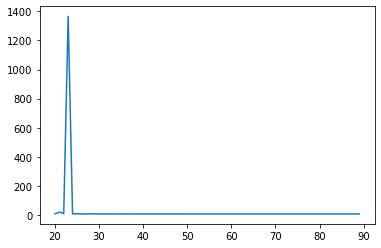

In [41]:
plt.plot(xs[20:],[y.item() for y in ys[20:]])

In [47]:
xs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
ys = [119.52702331542969, 603.3388061523438, 4829.845703125, 828393792.0, 93.27699279785156, 91.2274398803711, 443.8214416503906, 597.7467651367188, 89538.7578125, 45.516605377197266, 8.532577514648438, 21.84990119934082, 14.311190605163574, 24.592117309570312, 123.53816986083984, 33.007110595703125, 267.58587646484375, 110576.4921875, 8.249222755432129, 6.81900691986084, 6.980522155761719, 18.713106155395508, 9.170637130737305, 1366.7928466796875, 6.900881290435791, 7.809047698974609, 6.733803749084473, 6.836584091186523, 7.087950229644775, 6.8145833015441895, 6.717880725860596, 6.752406120300293, 6.797912120819092, 6.703051567077637, 6.713418006896973, 6.801753044128418, 6.735633373260498, 6.706026077270508, 6.715686798095703, 6.938708782196045, 6.725216388702393, 6.742655277252197, 6.718299865722656, 6.731109619140625, 6.869802474975586, 6.719986438751221, 6.737554550170898, 6.8809309005737305, 6.853152751922607, 6.707515716552734, 6.698742389678955, 6.702488899230957, 6.707519054412842, 6.728691577911377, 6.701158046722412, 6.6990156173706055, 6.698864936828613, 6.707967758178711, 6.699005603790283, 6.732588768005371, 6.698172092437744, 6.699856281280518, 6.718636989593506, 6.7059006690979, 6.702841758728027, 6.7123026847839355, 6.700403690338135, 6.704747200012207, 6.704222679138184, 6.699023246765137, 6.71103048324585, 6.701544761657715, 6.709853649139404, 6.700378894805908, 6.700655460357666, 6.701314449310303, 6.698904991149902, 6.697048664093018, 6.6972761154174805, 6.697368621826172, 6.697035789489746, 6.697251796722412, 6.697418212890625, 6.697259426116943, 6.697862148284912, 6.699279308319092, 6.69838809967041, 6.699851989746094, 6.700303077697754, 6.700693130493164]


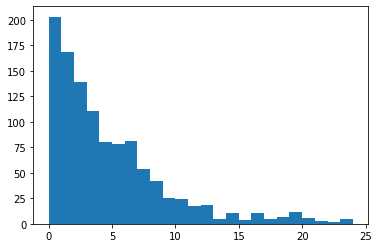

In [44]:
test(neural, test_x, test_y)

In [26]:
torch.save(neural.state_dict(), "neural_trained.pth")

In [27]:
xs, ys = train(linnet, lin_optim, lin_loss, lin_scheduler, train_x, train_y, valid_x, valid_y, 90, 200)

Starting epoch: 0
Epoch 0 ended with total avg. loss 344.0975404808396
Starting epoch: 1
Epoch 1 ended with total avg. loss 269.81246095666523
Starting epoch: 2
Epoch 2 ended with total avg. loss 215.71981689665364
Starting epoch: 3
Epoch 3 ended with total avg. loss 183.0423354148987
Starting epoch: 4
Epoch 4 ended with total avg. loss 136.06069702985582
Starting epoch: 5
Epoch 5 ended with total avg. loss 123.3911792167485
Starting epoch: 6
Epoch 6 ended with total avg. loss 94.99316636286974
Starting epoch: 7
Epoch 7 ended with total avg. loss 99.15893104657137
Starting epoch: 8
Epoch 8 ended with total avg. loss 74.99659493614624
Starting epoch: 9
Epoch 9 ended with total avg. loss 62.77114736797266
Starting epoch: 10
Epoch 10 ended with total avg. loss 60.2269144267544
Starting epoch: 11
Epoch 11 ended with total avg. loss 48.15200937806643
Starting epoch: 12
Epoch 12 ended with total avg. loss 38.0966774365421
Starting epoch: 13
Epoch 13 ended with total avg. loss 33.252026549728

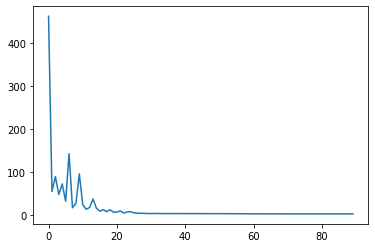

In [28]:
plt.plot(xs,[y.item() for y in ys])

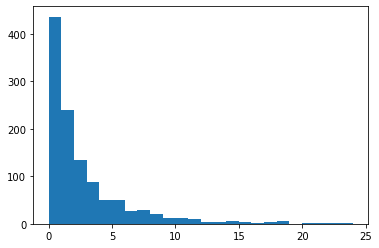

In [31]:
test(linnet, test_x, test_y)

In [29]:
torch.save(neural.state_dict(), "linear_trained.pth")